### Employee Retention

The goals of this challenge:

- Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: `day`, `employee_headcount`, `company_id`.

- What are the main factors that drive employee churn? Do they make sense? Explain your findings.

- If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import datetime
from sklearn import tree
import subprocess
import graphviz
import pydotplus
from sklearn.tree import export_graphviz
%matplotlib inline

### 1) Data Engineering

In [2]:
data = pd.read_csv('../Employee_retention/employee_retention_data.csv')
data.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


Lets change the type of `employee_id` column from float to int

In [4]:
data.employee_id = data.employee_id.astype(int)
data.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315,4,marketing,14,101000.0,2014-10-13,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [5]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [6]:
print('Number of unique employers',len(data.employee_id.unique()))
print('Number of unique companies',len(data.company_id.unique()))
print('Number of unique departments',len(data.dept.unique()))

('Number of unique employers', 24702)
('Number of unique companies', 12)
('Number of unique departments', 6)


In [7]:
data.describe(include=[np.object])

,dept,join_date,quit_date
count,24702,24702,13510
unique,6,995,664
top,customer_service,2012-01-03,2015-05-08
freq,9180,105,111


From the table one can see that more than a half of employees have quitted (13510 out of 24702).

In [8]:
data.groupby('dept').agg('count')

,employee_id,company_id,seniority,salary,join_date,quit_date
dept,,,,,,
customer_service,9180,9180,9180,9180,9180,5094
data_science,3190,3190,3190,3190,3190,1682
design,1380,1380,1380,1380,1380,778
engineer,4613,4613,4613,4613,4613,2362
marketing,3167,3167,3167,3167,3167,1783
sales,3172,3172,3172,3172,3172,1811


The majority of the personal is working in 'customer_service' department

dept
customer_service     82245.424837
marketing           135598.042311
sales               135912.358134
design              137460.869565
engineer            205544.548016
data_science        206885.893417
Name: salary, dtype: float64


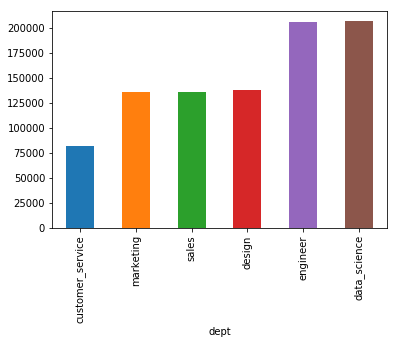

In [9]:
print(data.groupby('dept')['salary'].mean().sort_values())
data.groupby('dept')['salary'].mean().sort_values().plot(kind='bar')

The most common deptartment is **customer_service**, is also paid the least. There's likely a correlation between the likeliness to leave and the salary/pay of the job.

In [10]:
data.groupby('dept')['employee_id'].count().sort_values()

dept
design              1380
marketing           3167
sales               3172
data_science        3190
engineer            4613
customer_service    9180
Name: employee_id, dtype: int64

In [11]:
data.groupby('seniority').count()

,employee_id,company_id,dept,salary,join_date,quit_date
seniority,,,,,,
1,861,861,861,861,861,430
2,942,942,942,942,942,500
3,881,881,881,881,881,447
4,895,895,895,895,895,422
5,936,936,936,936,936,533
6,950,950,950,950,950,571
7,928,928,928,928,928,511
8,1008,1008,1008,1008,1008,586
9,944,944,944,944,944,522


Last two entries are likely to be outliers, therefore can be removed

In [12]:
data = data[data['seniority'] < 30]
data.groupby('seniority').count()

,employee_id,company_id,dept,salary,join_date,quit_date
seniority,,,,,,
1,861,861,861,861,861,430
2,942,942,942,942,942,500
3,881,881,881,881,881,447
4,895,895,895,895,895,422
5,936,936,936,936,936,533
6,950,950,950,950,950,571
7,928,928,928,928,928,511
8,1008,1008,1008,1008,1008,586
9,944,944,944,944,944,522


Next step is to create a new table that estimates employee headcount at each day.

In [13]:
data.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315,4,marketing,14,101000.0,2014-10-13,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [14]:
headcount_columns = ['date','employee_headcount','company_id']

The date period we want to look at are between **2011/01/24** to **2015/12/13.**

In [15]:
# We have to initialize the start and end dates as well as timestep (1 day)

start_date = datetime.date(2011,1,24)
end_date = datetime.date(2015,12,13)
day_step = datetime.timedelta(days=1)

# Create a list that will contain unique days between the specified timeframe

unique_days = []

while start_date <= end_date:
    
    unique_days.append(start_date.strftime('%Y-%m-%d'))
    start_date += day_step

print(len(unique_days))


1785


In [16]:
headcount_days = pd.DataFrame(unique_days)
headcount_days.head(5)

,0
0,2011-01-24
1,2011-01-25
2,2011-01-26
3,2011-01-27
4,2011-01-28


In [17]:
# now get unique company_id's

company_ids = pd.unique(data['company_id'])
headcount_company_ids = pd.DataFrame(company_ids)
headcount_company_ids

,0
0,7
1,4
2,2
3,9
4,1
5,6
6,10
7,5
8,3
9,8


Next step is to cross-join the **headcount_days** dataframe with **headcount_company_ids**. The resulting dataframe headcount should have len(headcount_dates)xlen(headcount_company_ids) which is 1785x12, or 21420. Reach row respresents a unique date with a unique company_id.

In [18]:
# first, create a common key for both dataframes to join on

headcount_days['key'] = 0
headcount_company_ids['key'] = 0

In [19]:
# now call the pd.merge() method to join the two dataframes

headcount = pd.merge(headcount_days, headcount_company_ids, on='key')
headcount.head(20)

,0_x,key,0_y
0,2011-01-24,0,7
1,2011-01-24,0,4
2,2011-01-24,0,2
3,2011-01-24,0,9
4,2011-01-24,0,1
5,2011-01-24,0,6
6,2011-01-24,0,10
7,2011-01-24,0,5
8,2011-01-24,0,3
9,2011-01-24,0,8


Would be useful to clean up the headcount dataframe by renaming columns and dropping the key column. We can do this by simply changing the key column's name to employee_headcount! Since it was initialized with value of 0, this also works to our advantage, since at the first day all companies start with 0 employees for our model.
Now, for every time frame (day) we have got twelve rows with corresponding `company_id` 

In [20]:
headcount.columns = headcount_columns
headcount.head(20)

,date,employee_headcount,company_id
0,2011-01-24,0,7
1,2011-01-24,0,4
2,2011-01-24,0,2
3,2011-01-24,0,9
4,2011-01-24,0,1
5,2011-01-24,0,6
6,2011-01-24,0,10
7,2011-01-24,0,5
8,2011-01-24,0,3
9,2011-01-24,0,8


In [21]:
data.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315,4,marketing,14,101000.0,2014-10-13,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22


Now we can need to fill the employee_headcount column. We do this by creating 2 more datasets, one for **joining employees** and other for **quitting employees**.

Lets group the employees dataframe by `join_date` and `company_id` and and use .size() to finds the occurences of each case (i.e. how many employees started for specific company_id at specific date) 

In [22]:
data.groupby([ "join_date", "company_id"]).size()

join_date   company_id
2011-01-24  1             25
            2             17
            3              9
            4             12
            5              5
            6              3
            7              1
            8              6
            9              3
2011-01-25  1              2
            2              2
            3              1
2011-01-26  1              2
            3              2
            4              1
            5              1
2011-01-31  1             30
            2             12
            3              7
            4              5
            5              7
            6              7
            7              6
            8              5
            9              3
            10             1
2011-02-01  1              7
            2              2
            3              1
            4              1
                          ..
2015-12-01  1              3
            2              3
            3       

Use to_frame() to convert the Series to DataFrame.
We should also reset indexes in order to return a new dataframe with single level index from multi-level index.

In [23]:
data_join = data.groupby([ "join_date", "company_id"]).size().to_frame(name='join_count').reset_index()
data_join.head(20)

,join_date,company_id,join_count
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
5,2011-01-24,6,3
6,2011-01-24,7,1
7,2011-01-24,8,6
8,2011-01-24,9,3
9,2011-01-25,1,2


In [24]:
# do the same for data_quit 

data_quit = data.groupby(['quit_date','company_id']).size().to_frame(name='quit_count').reset_index()
data_quit.tail(10)

,quit_date,company_id,quit_count
2714,2015-12-04,4,4
2715,2015-12-04,5,3
2716,2015-12-04,6,4
2717,2015-12-04,7,7
2718,2015-12-04,8,4
2719,2015-12-04,9,4
2720,2015-12-04,10,3
2721,2015-12-08,1,1
2722,2015-12-08,3,1
2723,2015-12-09,4,1


Now we are going to merge these two tables into headcount dataframe

In [25]:
# merge the data_join and data_quit dataframes with headcount

headcount = headcount.merge(data_join, left_on=['date','company_id'], 
                            right_on=['join_date','company_id'], how='outer')
headcount.head(5)

,date,employee_headcount,company_id,join_date,join_count
0,2011-01-24,0,7,2011-01-24,1.0
1,2011-01-24,0,4,2011-01-24,12.0
2,2011-01-24,0,2,2011-01-24,17.0
3,2011-01-24,0,9,2011-01-24,3.0
4,2011-01-24,0,1,2011-01-24,25.0


In [26]:
headcount = headcount.merge(data_quit, left_on=['date','company_id'], 
                            right_on=['quit_date','company_id'], how='outer')
headcount.head(5)

,date,employee_headcount,company_id,join_date,join_count,quit_date,quit_count
0,2011-01-24,0,7,2011-01-24,1.0,NaN,NaN
1,2011-01-24,0,4,2011-01-24,12.0,NaN,NaN
2,2011-01-24,0,2,2011-01-24,17.0,NaN,NaN
3,2011-01-24,0,9,2011-01-24,3.0,NaN,NaN
4,2011-01-24,0,1,2011-01-24,25.0,NaN,NaN


In [27]:
# drop 'join_date' and 'quit_date' columns
headcount = headcount.drop('join_date',1)
headcount = headcount.drop('quit_date',1)
# fill NaN values with 0
headcount = headcount.fillna(0)

headcount.head(20)

,date,employee_headcount,company_id,join_count,quit_count
0,2011-01-24,0,7,1.0,0.0
1,2011-01-24,0,4,12.0,0.0
2,2011-01-24,0,2,17.0,0.0
3,2011-01-24,0,9,3.0,0.0
4,2011-01-24,0,1,25.0,0.0
5,2011-01-24,0,6,3.0,0.0
6,2011-01-24,0,10,0.0,0.0
7,2011-01-24,0,5,5.0,0.0
8,2011-01-24,0,3,9.0,0.0
9,2011-01-24,0,8,6.0,0.0


In [28]:
headcount = headcount.sort_values(['date','company_id'])
headcount.head(20)

,date,employee_headcount,company_id,join_count,quit_count
4,2011-01-24,0,1,25.0,0.0
2,2011-01-24,0,2,17.0,0.0
8,2011-01-24,0,3,9.0,0.0
1,2011-01-24,0,4,12.0,0.0
7,2011-01-24,0,5,5.0,0.0
5,2011-01-24,0,6,3.0,0.0
0,2011-01-24,0,7,1.0,0.0
9,2011-01-24,0,8,6.0,0.0
3,2011-01-24,0,9,3.0,0.0
6,2011-01-24,0,10,0.0,0.0


In [29]:
headcount.describe()

,employee_headcount,company_id,join_count,quit_count
count,21420.0,21420.000000,21420.000000,21420.000000
mean,0.0,6.500000,1.153128,0.630626
std,0.0,3.452133,3.767533,2.728065
min,0.0,1.000000,0.000000,0.000000
25%,0.0,3.750000,0.000000,0.000000
50%,0.0,6.500000,0.000000,0.000000
75%,0.0,9.250000,0.000000,0.000000
max,0.0,12.000000,44.000000,38.000000


The sum of **join_count** should be total number of employees in the original dataframe (people who have joined, minus the 2 we took off for being outliers), which is 24700.

The sum of **quit_count** should be total number of employees in the original dataframe who had a quit date (again, minus 2 that we took off for being outliers), which is 13508.

Let's check this to make sure our headcount dataframe is correct.

In [30]:
if headcount['join_count'].sum() == 24700 and headcount['quit_count'].sum() == 13508:
    print('correct')
else:
    print ('please re-check your code for creating headcount dataframe!')

correct


In [31]:
headcount.head(20)

,date,employee_headcount,company_id,join_count,quit_count
4,2011-01-24,0,1,25.0,0.0
2,2011-01-24,0,2,17.0,0.0
8,2011-01-24,0,3,9.0,0.0
1,2011-01-24,0,4,12.0,0.0
7,2011-01-24,0,5,5.0,0.0
5,2011-01-24,0,6,3.0,0.0
0,2011-01-24,0,7,1.0,0.0
9,2011-01-24,0,8,6.0,0.0
3,2011-01-24,0,9,3.0,0.0
6,2011-01-24,0,10,0.0,0.0


In [32]:
headcount.describe()

,employee_headcount,company_id,join_count,quit_count
count,21420.0,21420.000000,21420.000000,21420.000000
mean,0.0,6.500000,1.153128,0.630626
std,0.0,3.452133,3.767533,2.728065
min,0.0,1.000000,0.000000,0.000000
25%,0.0,3.750000,0.000000,0.000000
50%,0.0,6.500000,0.000000,0.000000
75%,0.0,9.250000,0.000000,0.000000
max,0.0,12.000000,44.000000,38.000000


We need to calc cumulative sum for each `company_id` for each date. Let start with grouping the dataframe by `company_id` and select the column ('join_count' or 'quit_count') to run the cumulative sum on. 

In [33]:
headcount.groupby('company_id')['join_count'].cumsum()

4          25.0
2          17.0
8           9.0
1          12.0
7           5.0
5           3.0
0           1.0
9           6.0
3           3.0
6           0.0
10          0.0
11          0.0
16         27.0
14         19.0
20         10.0
13         12.0
19          5.0
17          3.0
12          1.0
21          6.0
15          3.0
18          0.0
22          0.0
23          0.0
28         29.0
26         19.0
32         12.0
25         13.0
31          6.0
29          3.0
          ...  
21384    1224.0
21393    1047.0
21387     961.0
21390     864.0
21394      16.0
21395      24.0
21400    8485.0
21398    4222.0
21404    2749.0
21397    2062.0
21403    1755.0
21401    1291.0
21396    1224.0
21405    1047.0
21399     961.0
21402     864.0
21406      16.0
21407      24.0
21412    8485.0
21410    4222.0
21416    2749.0
21409    2062.0
21415    1755.0
21413    1291.0
21408    1224.0
21417    1047.0
21411     961.0
21414     864.0
21418      16.0
21419      24.0
Name: join_count, Length

In [34]:
headcount.groupby('company_id')['quit_count'].cumsum()

4           0.0
2           0.0
8           0.0
1           0.0
7           0.0
5           0.0
0           0.0
9           0.0
3           0.0
6           0.0
10          0.0
11          0.0
16          0.0
14          0.0
20          0.0
13          0.0
19          0.0
17          0.0
12          0.0
21          0.0
15          0.0
18          0.0
22          0.0
23          0.0
28          0.0
26          0.0
32          0.0
25          0.0
31          0.0
29          0.0
          ...  
21384     692.0
21393     579.0
21387     529.0
21390     479.0
21394      12.0
21395      12.0
21400    4620.0
21398    2206.0
21404    1531.0
21397    1153.0
21403     983.0
21401     712.0
21396     692.0
21405     579.0
21399     529.0
21402     479.0
21406      12.0
21407      12.0
21412    4620.0
21410    2206.0
21416    1531.0
21409    1153.0
21415     983.0
21413     712.0
21408     692.0
21417     579.0
21411     529.0
21414     479.0
21418      12.0
21419      12.0
Name: quit_count, Length

The method transform() has to be called with 'cumsum' which returns pd.Series that is same size as the input. 

In [35]:
headcount['join_cumsum']  = headcount.groupby('company_id')['join_count'].transform(pd.Series.cumsum).to_frame() 
headcount['quit_cumsum']  = headcount.groupby('company_id')['quit_count'].transform(pd.Series.cumsum).to_frame()
headcount.head(20)

,date,employee_headcount,company_id,join_count,quit_count,join_cumsum,quit_cumsum
4,2011-01-24,0,1,25.0,0.0,25.0,0.0
2,2011-01-24,0,2,17.0,0.0,17.0,0.0
8,2011-01-24,0,3,9.0,0.0,9.0,0.0
1,2011-01-24,0,4,12.0,0.0,12.0,0.0
7,2011-01-24,0,5,5.0,0.0,5.0,0.0
5,2011-01-24,0,6,3.0,0.0,3.0,0.0
0,2011-01-24,0,7,1.0,0.0,1.0,0.0
9,2011-01-24,0,8,6.0,0.0,6.0,0.0
3,2011-01-24,0,9,3.0,0.0,3.0,0.0
6,2011-01-24,0,10,0.0,0.0,0.0,0.0


In [36]:
headcount['employee_headcount'] = headcount['join_cumsum'] - headcount['quit_cumsum']
headcount_final = headcount[['date','company_id','employee_headcount']]
headcount_final.head(10)

,date,company_id,employee_headcount
4,2011-01-24,1,25.0
2,2011-01-24,2,17.0
8,2011-01-24,3,9.0
1,2011-01-24,4,12.0
7,2011-01-24,5,5.0
5,2011-01-24,6,3.0
0,2011-01-24,7,1.0
9,2011-01-24,8,6.0
3,2011-01-24,9,3.0
6,2011-01-24,10,0.0


At last, we have the final dataframe headcount which contains the three columns the exercise asks for.

### 2) EDA

In [37]:
headcount.head(10)

,date,employee_headcount,company_id,join_count,quit_count,join_cumsum,quit_cumsum
4,2011-01-24,25.0,1,25.0,0.0,25.0,0.0
2,2011-01-24,17.0,2,17.0,0.0,17.0,0.0
8,2011-01-24,9.0,3,9.0,0.0,9.0,0.0
1,2011-01-24,12.0,4,12.0,0.0,12.0,0.0
7,2011-01-24,5.0,5,5.0,0.0,5.0,0.0
5,2011-01-24,3.0,6,3.0,0.0,3.0,0.0
0,2011-01-24,1.0,7,1.0,0.0,1.0,0.0
9,2011-01-24,6.0,8,6.0,0.0,6.0,0.0
3,2011-01-24,3.0,9,3.0,0.0,3.0,0.0
6,2011-01-24,0.0,10,0.0,0.0,0.0,0.0


In [38]:
x_values = range(len(unique_days))

y_join = headcount.groupby('date')['join_count'].sum()
y_quit = headcount.groupby('date')['quit_count'].sum()

# also take a look at monthly averages

rolling_avg_days = 30

y_join_rolling = y_join.rolling(rolling_avg_days).mean()
y_quit_rolling = y_quit.rolling(rolling_avg_days).mean()

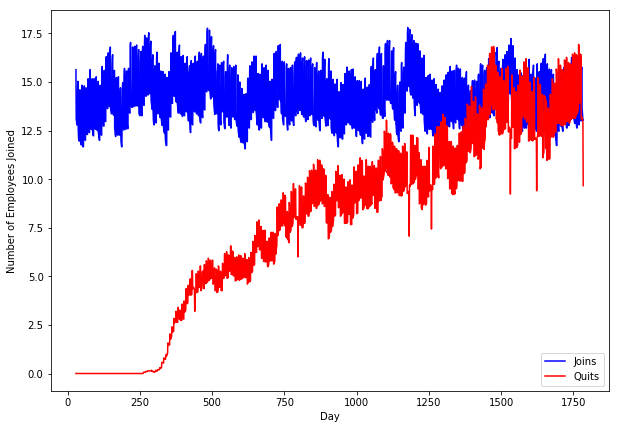

In [39]:
# plotting code

fig, ax = plt.subplots(figsize=(10,7))

join_line = ax.plot(x_values, y_join_rolling, color='b')
quit_line = ax.plot(x_values, y_quit_rolling, color='r')

ax.set_xlabel('Day')
ax.set_ylabel('Number of Employees Joined')
ax.legend((join_line[0], quit_line[0]),('Joins','Quits'))

plt.show()

The data is very noisy, and all this shows is that while the number of people who join stays relatively constant, the number of people who quit everyday starts to increase starting around day 300. And by the time you get to day ~1500 (about 4.5 years), the number of people quitting and joining are roughly the same.

Instead of this, let's take a look at histogram of how long each employee works before quitting.

In [40]:
# calculate employment length by taking the difference between quit_date and join_date
data['employment_length'] = pd.to_datetime(data['quit_date'], dayfirst=True) - pd.to_datetime(data['join_date'], dayfirst=True)

# dt.days attribute converts pandas datetime object to a float for histogram purposes
data['employment_length'].dt.days

0         585.0
1         340.0
2           NaN
3         389.0
4        1040.0
5         578.0
6           NaN
7           NaN
8        1047.0
9           NaN
10        837.0
11          NaN
12        340.0
13       1194.0
14        340.0
15        409.0
16        723.0
17          NaN
18          NaN
19          NaN
20          NaN
21        340.0
22       1316.0
23        360.0
24        368.0
25        619.0
26          NaN
27        347.0
28        795.0
29       1152.0
          ...  
24670     606.0
24671    1271.0
24672     280.0
24673     828.0
24674     417.0
24675     340.0
24676     310.0
24677     396.0
24678     333.0
24679       NaN
24680       NaN
24681       NaN
24682       NaN
24683       NaN
24684     423.0
24685    1033.0
24686     371.0
24687     655.0
24688       NaN
24689     445.0
24690    1452.0
24691       NaN
24692     424.0
24693       NaN
24694       NaN
24695    1151.0
24696     372.0
24697       NaN
24698       NaN
24699     780.0
Name: employment_length,

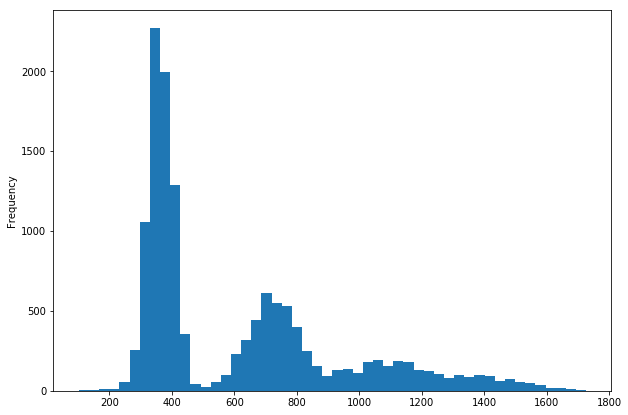

In [41]:
data['employment_length'].dt.days.plot.hist(bins=50, figsize=(10,7))

Ok, so there are peaks in the number of days worked before quitting: 1 year mark, with 2nd peak coming at 2 year mark, and another smaller peak at 3 year mark and so on...

It will be interesting to look at the plot of the employee headcount for each company throughout the year.

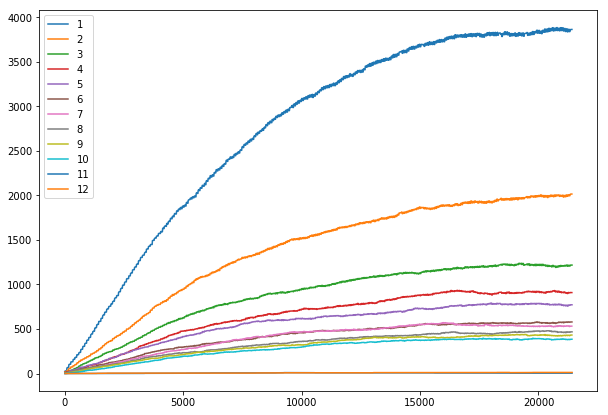

In [42]:
plt.figure(figsize=(10,7))
for key, group in headcount.groupby('company_id'):
    plt.plot(group['employee_headcount'], label=key)
plt.legend(loc='best')

### 3) Modeling

It was shown that most of the employees are leaving the companies after approximately one year of working. This means the employee is quitting after the company has invested time and money into making the employee effective. Let's find what are the most important features for what makes an employee quit early.

Lets create binary feature `quit_early` that reflects this early leaving (we take 1.5 year boundary)

In [43]:
data['quit_early'] = np.where(data['employment_length'].dt.days <= 548, 1, 0)
data.groupby('quit_early').count()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length
quit_early,,,,,,,,
0,17305,17305,17305,17305,17305,17305,6113,6113
1,7395,7395,7395,7395,7395,7395,7395,7395


Looks like about ~40% of the employees end up quitting early (within 1.5 years). Now re-arrange the data and train simple the decision tree.

In [44]:
x_train = data[['dept','seniority','salary']]
x_train.head(10)

,dept,seniority,salary
0,customer_service,28,89000.0
1,marketing,20,183000.0
2,marketing,14,101000.0
3,customer_service,20,115000.0
4,data_science,23,276000.0
5,data_science,14,165000.0
6,customer_service,21,107000.0
7,customer_service,4,30000.0
8,engineer,7,160000.0
9,sales,7,104000.0


In [45]:
# Transform categorical features into binary

x_train = pd.get_dummies(x_train,'dept')
y_label = data['quit_early']
x_train.head(20)

,seniority,salary,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,1,0,0,0,0,0
1,20,183000.0,0,0,0,0,1,0
2,14,101000.0,0,0,0,0,1,0
3,20,115000.0,1,0,0,0,0,0
4,23,276000.0,0,1,0,0,0,0
5,14,165000.0,0,1,0,0,0,0
6,21,107000.0,1,0,0,0,0,0
7,4,30000.0,1,0,0,0,0,0
8,7,160000.0,0,0,0,1,0,0
9,7,104000.0,0,0,0,0,0,1


In [47]:
# fit to decision tree model with max_depth = 2 and min_samples_leaf = 1% of total dataset 

dt = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=len(y_label)/100)
tree_model = dt.fit(x_train,y_label)

In [48]:
tree_model.feature_importances_

array([0.01270862, 0.98729138, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

`Seniority` and `Salary`...

In [49]:
x_train.columns[tree_model.tree_.feature]
x_train.columns

Index([u'seniority', u'salary', u'dept_customer_service', u'dept_data_science',
       u'dept_design', u'dept_engineer', u'dept_marketing', u'dept_sales'],
      dtype='object')

Looks like the dominant features to split on were salary, and marketing department. Looking back at salary data for each department, we note that marketing has the 2nd lowest salary, although customer service has the lowest salary.

In [50]:
# displays graphviz visualization of the decision tree on the notebook
def visualize_tree(dtree, feature_names):
    tree.export_graphviz(dtree, out_file='tree.dot')
    with open('tree.dot') as f:
        dot_graph = f.read()
        print dot_graph
    graphviz.Source(dot_graph)

In [51]:
visualize_tree(tree_model,x_train.columns)

digraph Tree {
node [shape=box] ;
0 [label="X[1] <= 223500.0\ngini = 0.42\nsamples = 24700\nvalue = [17305, 7395]"] ;
1 [label="X[1] <= 71500.0\ngini = 0.433\nsamples = 21124\nvalue = [14428, 6696]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[1] <= 60500.0\ngini = 0.392\nsamples = 5147\nvalue = [3770, 1377]"] ;
1 -> 2 ;
3 [label="gini = 0.379\nsamples = 3410\nvalue = [2544, 866]"] ;
2 -> 3 ;
4 [label="gini = 0.415\nsamples = 1737\nvalue = [1226, 511]"] ;
2 -> 4 ;
5 [label="X[1] <= 181500.0\ngini = 0.444\nsamples = 15977\nvalue = [10658, 5319]"] ;
1 -> 5 ;
6 [label="gini = 0.448\nsamples = 12938\nvalue = [8547, 4391]"] ;
5 -> 6 ;
7 [label="gini = 0.424\nsamples = 3039\nvalue = [2111, 928]"] ;
5 -> 7 ;
8 [label="X[1] <= 276500.0\ngini = 0.315\nsamples = 3576\nvalue = [2877, 699]"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="X[0] <= 17.5\ngini = 0.357\nsamples = 1928\nvalue = [1479, 449]"] ;
8 -> 9 ;
10 [label="gini = 0.393\

In [52]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [53]:
tree_graph_to_png(tree=tree_model, feature_names=x_train.columns, 
                  png_file_to_save='../Employee_retention/tree.png')

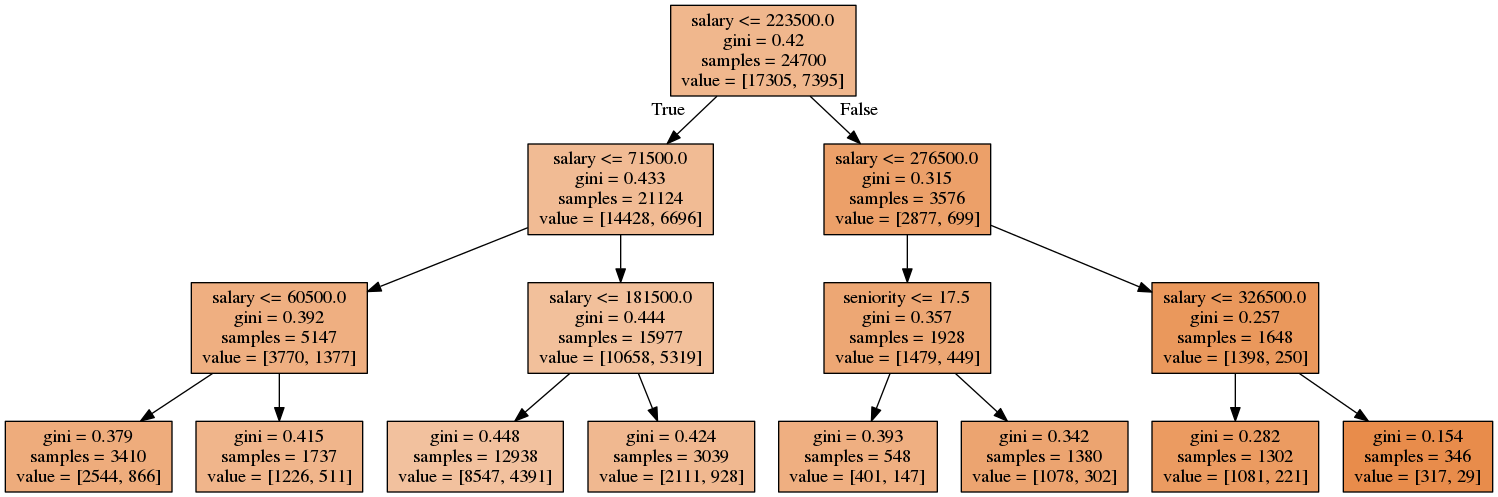

When rendered in graphviz, this gives the condition of salary split at the root node of 223,500. It then splits more based mostly on salary. Seniority is also one of the nodes as well.

In [54]:
data.groupby('quit_early')['salary'].mean()

quit_early
0    140698.815371
1    132273.292765
Name: salary, dtype: float64

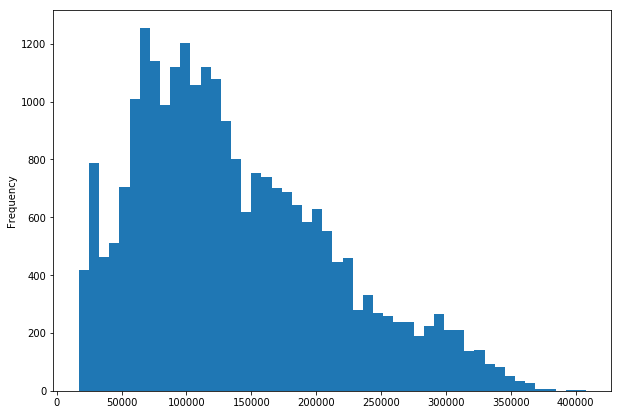

In [55]:
data['salary'].plot.hist(bins=50, figsize=(10,7))

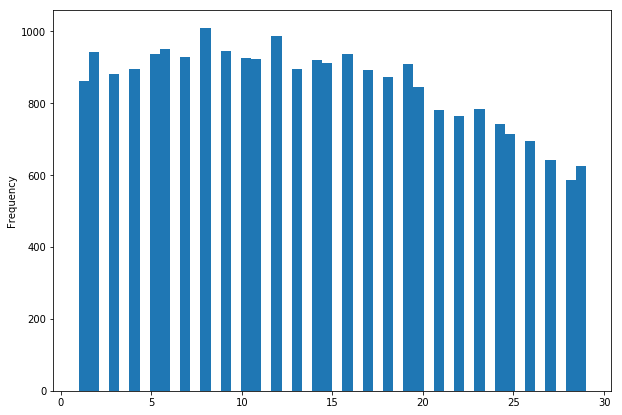

In [56]:
data['seniority'].plot.hist(bins=50, figsize=(10,7))

#### Conclusions¶

- Clearly, salary and seniority has an effect on the likeliness of an employee to quit, especially early (within 1.5 years). However, it's ot the lowest salaried employees who are most likely to quit, it's people just above this. There are few reasons for this. First is that the lowest salaried employees are often fresh out of college and need to build experience before moving to another company. Therefore, they are likely to stay beyond 1 year.

- We find that seniority has little effect on who quits until at around 20 years. This makes sense, as employees who have 20+ years of experience are likely looking to retire soon, and it does not make sense to leave a new job so early. They are looking to stay for a long time.


- If I could add one feature to the dataset, I would add employee satisfaction, as it might help explain the peaks/troughs in the quitting percentile. Then, I would add information about whether an employee is getting a bonus at the end of their year. This might explain why there is a large peak of people quitting after their first year, and then a second peak after their second year. With the information on whether they get a bonus, it might explain why there are some employees who quit after their second year instead of after their first (if they don't get a bonus the first year).